# Predict tags on StackOverflow with linear models

In this assignment you will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Data

You can find all data required for this assignment into the folder `/data`.

### Text preprocessing

For this assignment you will need to use a list of stop words. It can be downloaded from *nltk*:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Stat NLP/StatNLP_Project')

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [0]:
from ast import literal_eval
import pandas as pd
import numpy as np

Literal_eval package takes care of the preprocessing for the string so that it can be used in python. To know more on literal_eval please see the below documentation <br>
https://kite.com/python/docs/ast.literal_eval

In [5]:
%matplotlib inline
import re
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Task 1: Create training, testing and validation data from the files given. Use title to be the independent variable and tags to be the dependent variable ( 5 points)

Note: Ensure you apply literal_eval function on the tags column to ensure all the tags are readable in python

In [0]:
def processData(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [0]:
train = processData('train.tsv')
validation = processData('validation.tsv')
test = pd.read_csv('test.tsv', sep='\t')

In [8]:
print(train.head())


                                               title                  tags
0                How to draw a stacked dotplot in R?                   [r]
1  mysql select all records where a datetime fiel...          [php, mysql]
2             How to terminate windows phone 8.1 app                  [c#]
3  get current time in a specific country via jquery  [javascript, jquery]
4                      Configuring Tomcat to Use SSL                [java]


In [0]:
X_train, Y_train = train['title'].values, train['tags'].values
X_val, Y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [10]:
validation.iloc[0]['title']

'Why odbc_exec always fail?'

## Task 2 (Pre-processing). Implement the function *text_prepare* following the instructions. After that, run the function *test_test_prepare* to test it on tiny cases. (10 points)

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5*, *?*,  *{}*, etc. To prevent the problems, it's usually useful to prepare the data in a custom way


In [0]:
import re

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    #text = # lowercase text
    text =text.lower()
    #text = # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    #text = # delete symbols which are in BAD_SYMBOLS_RE from text
    text =  re.sub(BAD_SYMBOLS_RE, '', text)
    #text = # delete stopwords from text
    token_word=word_tokenize(text)
    filtered_sentence = [w for w in token_word if not w in STOPWORDS] # filtered_sentence contain all words that are not in stopwords dictionary
    lenght_of_string=len(filtered_sentence)
    text_new=""
    for w in filtered_sentence:
        if w!=filtered_sentence[lenght_of_string-1]:
             text_new=text_new+w+" " # when w is not the last word so separate by whitespace
        else:
            text_new=text_new+w
            
    text = text_new
    return text


In [0]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

Execute the test_text_prepare function

In [14]:
print(test_text_prepare())

Basic tests are passed.


*Note: You should pass the above test to ensure the text preprocessing is done before our analysis*

Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [0]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

Print the top 5 elements in x_train

In [16]:
X_train[0:5]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app',
 'get current time specific country via jquery',
 'configuring tomcat use ssl']

## Task 2 (WordsTagsCount) - Find 3 most popular tags and 3 most popular words in the train data. - 5 points

Note: The words which appear the most are considered as popular in this case!

In [17]:
print(len(X_train))

tags_counts = {}
words_counts = {}
def c_counter(corpus_list):
    a_dict= {}
    for corp in corpus_list:
        if type(corp) == type('keyword'):
            for word in corp.split():
                if word not in a_dict.keys():
                    a_dict[word] = 1
                else:   
                     a_dict[word] = a_dict[word] + 1
        else:
            for word in corp:
                if word not in a_dict.keys():
                    a_dict[word] = 1
                else:   
                     a_dict[word] = a_dict[word] + 1
            
    return a_dict
                
words_counts = c_counter(X_train)

tags_counts = c_counter(list(Y_train))

items = [(v, k) for k, v in tags_counts.items()]
items.sort()
items.reverse()
items[:5]

100000


[(19078, 'javascript'),
 (19077, 'c#'),
 (18661, 'java'),
 (13907, 'php'),
 (8940, 'python')]

We are assuming that *tags_counts* and *words_counts* are dictionaries like `{'some_word_or_tag': frequency}`. After applying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`.

eg: 
Tag 1 - 100 Tag 2 - 65 Tag 3 - 250 <br>
after sorting looks like, <br>
Tag 3 - 250 Tag 1 - 100 Tag 2 - 65

In [18]:
# Dictionary of all tags from train corpus with their counts.
#tags_counts = tag_counts
# Dictionary of all words from train corpus with their counts.
words_counts = c_counter(X_train)
print(tags_counts)
print(tags_counts.keys())
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]


print(most_common_words)

{'r': 1727, 'php': 13907, 'mysql': 3092, 'c#': 19077, 'javascript': 19078, 'jquery': 7510, 'java': 18661, 'ruby-on-rails': 3344, 'ruby': 2326, 'ruby-on-rails-3': 692, 'json': 2026, 'spring': 1346, 'spring-mvc': 618, 'codeigniter': 786, 'class': 509, 'html': 4668, 'ios': 3256, 'c++': 6469, 'eclipse': 992, 'python': 8940, 'list': 693, 'objective-c': 4338, 'swift': 1465, 'xaml': 438, 'asp.net': 3939, 'wpf': 1289, 'multithreading': 1118, 'image': 672, 'performance': 512, 'twitter-bootstrap': 501, 'linq': 964, 'xml': 1347, 'numpy': 502, 'ajax': 1767, 'django': 1835, 'laravel': 525, 'android': 2818, 'rest': 456, 'asp.net-mvc': 1244, 'web-services': 633, 'string': 1573, 'excel': 443, 'winforms': 1468, 'arrays': 2277, 'c': 3119, 'sockets': 579, 'osx': 490, 'entity-framework': 649, 'mongodb': 350, 'opencv': 401, 'xcode': 900, 'uitableview': 460, 'algorithm': 419, 'python-2.7': 421, 'angularjs': 1353, 'dom': 400, 'swing': 759, '.net': 3872, 'vb.net': 1918, 'google-maps': 408, 'hibernate': 807, '

## Task - 3 Transforming text to a vector (10 points)

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_my_bag_of_words*.

In [19]:
DICT_SIZE = 5000
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:5000] #most_common_words contain 5000 words in sorted order of frequncy
WORDS_TO_INDEX={}
INDEX_TO_WORDS={}
for i in range(0,5000):
    WORDS_TO_INDEX[most_common_words[i][0]]=i   # most_common_words[i][0] means extracting ith word from the dictioaanry, words to index conatain the index value of the word
    INDEX_TO_WORDS[i]=most_common_words[i][0] # index to word conatain the word conrrespond to the index

ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    y=text.split(" ")
    for i in range(0,len(y)):
        for key,value in words_to_index.items():
            if y[i]==key:
                result_vector[words_to_index[key]]=result_vector[words_to_index[key]]+1  #  result_vector[words_to_index[key]] conatin the count of the presence of  word in the text
            
    return result_vector # result vector is the vector of the size of the no of words taken as features having count of then in the text

print("My bag of words completed")


My bag of words completed


In [0]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

Execute the test_text_prepare function <br>
*<u>Note:</u> You should pass the above test to ensure BOW is working correctly!*

In [21]:
print(test_my_bag_of_words())

Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

In [0]:
from scipy import sparse as sp_sparse

In [23]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many types: of such representations, however sklearn algorithms can work only with  csr matrix, so we will use this one.<br>
<u>Documentations on sparse matrix:</u> <br>
(https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) 
(https://docs.scipy.org/doc/scipy/reference/sparse.html)




For the 11th row in *X_train_mybag* find how many non-zero elements it has. In this task the answer (variable *non_zero_elements_count*) should be a number, e.g. 20.

In [24]:
row = X_train_mybag[11].toarray()[0]
non_zero_elements_count=0
for i in range(0,5000):
    if (row[i]==1):
        non_zero_elements_count=non_zero_elements_count+1
    

print(non_zero_elements_count)




5


## Task 4 - TF-IDF (5 points)

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class  from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

## Write a function which takes x_train, x_val and x_test as input and return the tf-idf features of the same and the vocabulary

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
print(X_train[:3])

['draw stacked dotplot r', 'mysql select records datetime field less specified value', 'terminate windows phone 81 app']


In [0]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    tfidf_vectorizer =  TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')#  '(\S+)'  means any no white space
    X_train=tfidf_vectorizer.fit_transform(X_train)
    X_val=tfidf_vectorizer.transform(X_val)
    X_test=tfidf_vectorizer.transform(X_test)
   
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [0]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

Print the index of string "C#" in the vocabulary

In [28]:
print('X_test_tfidf ', X_test_tfidf.shape) 
print('X_val_tfidf ',X_val_tfidf.shape)

print('Index of c #'+str(tfidf_vocab['c #']))

X_test_tfidf  (20000, 18026)
X_val_tfidf  (30000, 18026)
Index of c #1920


## Task 5: Classification (15 points)
MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use MultiLabelBinarizer from sklearn. <br>
<u>Documentation:</u> <br>
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

In [0]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
Y_train = mlb.fit_transform(Y_train)
Y_val = mlb.fit_transform(Y_val)

In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

**OneVsRest multi-label strategy**

The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

**Logistic Regression & SVM**

OneVsRest strategy can be used for multi-label learning, where a classifier is used to predict multiple labels for instance. LR & SVM supports multi-class, but we are in a multi-label scenario, therefore, we wrap classifiers in the OneVsRestClassifier.

*If you want to learn more about OneVsRest, check out these links:*
- *https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5*
- *https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff*
- *https://medium.com/coinmonks/multi-label-classification-blog-tags-prediction-using-nlp-b0b5ee6686fc*

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

In [0]:
def train_classifier(X_train, Y_train):
    # Create and fit LogisticRegression and LinearSVC wraped into OneVsRestClassifier.

    clf= OneVsRestClassifier(LogisticRegression()).fit(X_train, Y_train)
    
    return clf  ### clf is the model

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.
classifier_mybag = model for 

In [33]:
classifier_mybag = train_classifier(X_train_mybag, Y_train)
classifier_tfidf = train_classifier(X_train_tfidf, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [0]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

## Evaluation (10 points)

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. If you want a refresher, you can click the link to their documentation

## Import the necessary libraries for the above metrics

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Define the function *print_evaluation_scores* which takes y_val and predicted as input calculates and prints the following output:
 - *accuracy*
 - *F1-score - Average = 'weighted'* 
 - *Precision - Average = 'macro'*

In [0]:
def print_evaluation_scores(Y_val, predicted):
    acc = accuracy_score(Y_val, predicted, normalize=True, sample_weight=None)
    precision_macro = average_precision_score(Y_val, predicted, average='macro', sample_weight=None)
    precision_micro = average_precision_score(Y_val, predicted, average='micro', sample_weight=None)
    precision_weight = average_precision_score(Y_val, predicted, average='weighted', sample_weight=None)
    f1_macro = average_precision_score(Y_val, predicted, average='macro', sample_weight=None)
    f1_micro = average_precision_score(Y_val, predicted, average='micro', sample_weight=None)
    f1_weight = average_precision_score(Y_val, predicted, average='weighted', sample_weight=None)
    return acc, precision_macro, precision_micro, precision_weight, f1_macro, f1_micro,f1_weight


In [37]:
print('Bag-of-words')
print_evaluation_scores(Y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(Y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Tfidf


(0.33366666666666667,
 0.30075521722803006,
 0.4552773512290578,
 0.483600447051642,
 0.30075521722803006,
 0.4552773512290578,
 0.483600447051642)

You might also want to plot some form of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. The input parameters for the roc curve are:
 - true labels
 - decision functions scores
 - number of classes

Import the roc_auc function from the metrics.py file provided

In [0]:
from metrics import roc_auc
%matplotlib inline

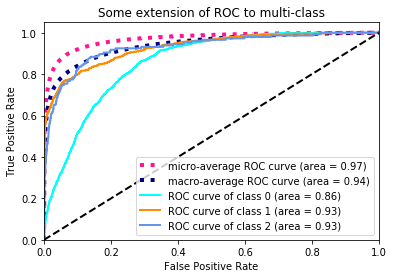

In [39]:
n_classes = len(tags_counts)
roc_auc(Y_val, y_val_predicted_scores_mybag, n_classes)

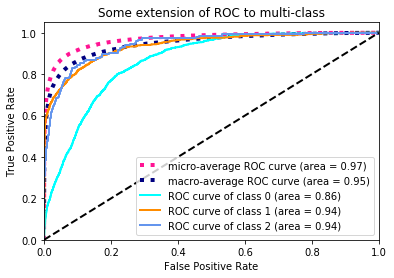

In [40]:
roc_auc(Y_val, y_val_predicted_scores_tfidf, n_classes)

## Task 4 (MultilabelClassification) - Optional 
** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).



In [0]:
######################################
######### YOUR CODE HERE #############
######################################

When you are happy with the quality, create predictions for *test* set.